<a href="https://colab.research.google.com/github/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/block_03_optical_flow_and_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nowcasting methods

In this notebook we show how to construct, visualize, apply verification metrics to and export a deterministic and probablistic (ensemble) nowcast using pysteps.


First we install pysteps and load the example data by running the [helper_input_data](https://github.com/pySTEPS/ERAD-nowcasting-course-2022/blob/hands-on-users/hands-on-session-users/notebooks/helper_input_data.ipynb) notebook.

In [1]:
from google.colab import drive
import os
# mount the Google Drive folder
# don't attempt to remount if the drive is already mounted
if not os.path.exists("/content/mnt/MyDrive"):
  drive.mount("mnt")
%cd '/content/mnt/MyDrive/Colab Notebooks'
# run the data notebook to load the input dataset
%run helper_input_data.ipynb

MessageError: ignored

## Pre-processing steps
We will start with a few pre-processing steps that are the same for the deterministic and probablistic forecasts. These pre-processing steps resemble the steps from block 2 and 3 (so you could also continue with your scripts from those exercises). 

### Import the data and apply data transformations


In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from pysteps import motion
from pysteps.utils import transformation
from pysteps.visualization import plot_precip_field, quiver

methods = ["LK", "VET", "DARTS"]
plt.figure(figsize=(18, 6))

# When computing the optical flow, transforming the precipitation rates (mm/h)
# to dBR via the logarithmic transform shown in the previous exercise generally
# improves the reliability of the estimation.
precip_dbr, metadata_dbr = transformation.dB_transform(
    precip,
    metadata,
    threshold=0.1,
    zerovalue=-15.0
)

# Handling of NaN values has been explicitly implemented in Lucas-Kanade and VET,
# but not in DARTS. For this reason, we set all non-finite values to the minimum
# value before applying the optical flow.
precip_finite = precip_dbr.copy()
precip_finite[~np.isfinite(precip_finite)] = np.nanmin(precip_dbr)

### Determine the motion field
Determine the motion field (pick a method from block 3) and visualize it.

In [ ]:
for i, method in enumerate(methods):
    # Use get_method to get a callable function for the chosen method
    oflow = motion.get_method(method)

    starttime = time.time()

    if method == "LK":
        # Use six most recent precipitation fields (30 minutes) for Lucas-Kanade
        # Disable printing with verbose=False
        motion_field = oflow(precip_finite[-6:], verbose=False)
    elif method == "VET":
        # VET takes two or three input fields
        motion_field = oflow(precip_finite[-3:], verbose=False)
    elif method == "DARTS":
        # Use twelve most recent precipitation fields (one hour) for DARTS that
        # performs the best when supplied with a long time series
        motion_field = oflow(precip_finite[-12:], verbose=False)

    print(f"Optical flow computation with {method} took {time.time() - starttime:.03f} seconds")

    plt.subplot(131 + i)
  
    plot_precip_field(precip[-1], geodata=metadata, title=method)
    quiver(motion_field, geodata=metadata, step=15, quiver_kwargs={"scale": 50})

plt.show()

## Deterministic nowcasts

Will follow..

## Probabilistic nowcasts
In the second part, we are basically going to repeat the steps of the deterministic nowcast, but we will construct a probabilistic nowcast with 20 ensemble members and verify this nowcast accordingly. 
If time allows, you can also try to make a LINDA-P nowcast.

To do..
Using the estimated advection field, we can now apply the semi-Lagrangian extrapolation. In pysteps we have implemented the method described in [4] in [extrapolation.semilagrangian.extrapolate](https://pysteps.readthedocs.io/en/stable/generated/pysteps.extrapolation.semilagrangian.extrapolate.html#pysteps.extrapolation.semilagrangian.extrapolate).

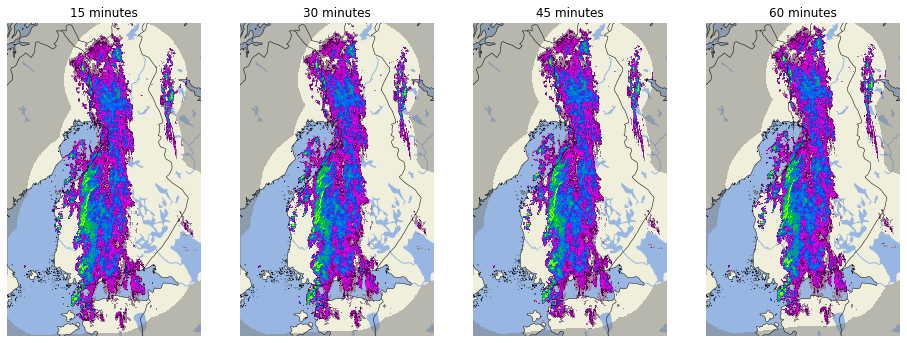

In [ ]:
from pysteps.extrapolation.semilagrangian import extrapolate

# Extrapolate the last observed precipitation field to 12 time steps (one hour)
# forward in 5-minute time steps. The composite contains NaN values outside the
# radar domain, so we need to use the allow_nonfinite_values option.
precip_extrap = extrapolate(precip[-1], motion_field, 12, allow_nonfinite_values=True)

plt.figure(figsize=(16, 10))

# Here we plot only for time steps. Note that even if we are interested in a
# small number of future time steps, the extrapolation should be done by using
# as large number of time steps (and iterations, see the n_iter argument) as
# possible to achieve the best accuracy. This is because we are integrating the
# movement of precipitation along a nonlinear advection field.
for i, j in enumerate(range(2, 13, 3)):
    plt.subplot(1, 4, 1 + i)
    plot_precip_field(precip_extrap[j], geodata=metadata, colorbar=False)
    plt.title(f"{(j + 1) * 5} minutes")

plt.show()

For a list of additional arguments, see the [pysteps documentation](https://pysteps.readthedocs.io/en/stable/generated/pysteps.extrapolation.semilagrangian.extrapolate.html#pysteps.extrapolation.semilagrangian.extrapolate).

## References


[1] 